In [1]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
tf.set_random_seed(1234)
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")

In [2]:
class learning_agent(object):
    '''
        define a sample actor critic reinforcement learning agent with 2 fully
        connected layers for both actor and critic networks
    '''
    def __init__(self, env, batch_n, gamma = 0.99, expo_rate = 0, learning_rate = 0.001):
        # ---------------- hyper parameters -------------------
        self.env = env                      # environment
        self.gamma = gamma                  # decay factor
        self.expo_rate = expo_rate          # weight for entropy term
        self.learning_rate = learning_rate  # learning rate for agent
        # ---------------- internal data ----------------------
        self.trajectory = []             # sequence of state history
        self.reward_traj = []            # sequence of reward history
        self.action_traj = []            # sequence of action history
        self.batch_num = batch_n         # number of trajectory used for learning
        self.batch_count = 0             # record current batch count
        self.batch_data = {}             # dictionary store trajcetoy info
        self.save_freq = 0               # tracking frequency of saving memory 
        self.critic_buffer = {}          # dictionary store data for critic network learning
        self.critic_buffer['target_value'] = []   # TD target
        self.critic_buffer['next_st_value'] = []  # value of next state
        self.next_state = []                      # state offset
        
        # define network structure (state input and action output by environment definition)
        self.state, self.a_mean, self.a_sigma, self.value =  self.build_net(self.env)
        self.action_tr = tf.placeholder(tf.float32, [None, env.action_space.shape[0]])
        self.total_reward = tf.placeholder(tf.float32, [None, 1])
        
        # sample action based on gaussian policy
        rv_I = tf.random_normal([1, env.action_space.shape[0]], 
                                mean=0.0, stddev=1.0, dtype=tf.float32, seed=None)
        self.sample_action = tf.clip_by_value(tf.add(self.a_mean, tf.multiply(self.a_sigma, rv_I)), 
                                              env.action_space.low.tolist(), 
                                              env.action_space.high.tolist())
        
        # define critic network and loss by TD method
        self.target_value = tf.placeholder(tf.float32, [None, 1])
        self.critic_loss = tf.reduce_mean(tf.square(self.target_value - self.value))
        self.optimizer_critic = tf.train.AdamOptimizer(self.learning_rate).minimize(self.critic_loss)
        
        # define loss for policy network 
        self.prob = tf.contrib.distributions.Normal(loc = self.a_mean, scale = self.a_sigma)
        self.log_r_sum = tf.multiply(self.prob.log_prob(self.action_tr), (self.total_reward - self.value))
        self.entropy = self.prob.entropy()
        self.loss = tf.reduce_mean(-self.log_r_sum) - self.expo_rate * self.entropy# reduce sum and add expo
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        # start session
        self.sess = tf.Session()
        self.saver=tf.train.Saver()
        self.sess.run(tf.global_variables_initializer())
        
        # check nn memory existance
        my_file = Path("memory/model.ckpt.index")
        if my_file.is_file():
            self.saver.restore(self.sess,"memory/model.ckpt")
            print("model restore")
        else:
            print("start new file")
            try:
                os.makedirs('memory')
            except OSError as e:
                pass
            
    
    def build_net(self, env):
        '''
            openAI gym environment as input to setup input and output layers of
            actor and critic networks. Actor and Critic both have 2 layers.
        '''
        act_shape = env.action_space.shape[0]
        obs_shape = env.observation_space.shape[0]
        state = tf.placeholder(tf.float32, [None, obs_shape])
        
        # actor network 
        l1 = tf.layers.dense(inputs = state, units = 128, activation = tf.nn.relu, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), 
                             name = "policy_l1")
        
        l2 = tf.layers.dense(inputs = l1, units = 64, activation = tf.nn.relu, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), 
                             name = "policy_l2")
        
        p_mean = tf.layers.dense(inputs = l2, units = act_shape, activation = tf.nn.tanh, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), 
                             name = "action_mean")

        p_sigma = tf.layers.dense(inputs = l2, units = act_shape, activation = tf.nn.softplus, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1), 
                             name = "action_std") + 1e-8

        scale_action_mean = tf.multiply(p_mean, 
                                        np.array([env.action_space.high.tolist()]), 
                                        name = "scale_action_mean")
        
        # critic network
        l3 = tf.layers.dense(inputs = state, units = 64, activation = tf.nn.relu, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1),
                             name = "critic_l1")
        
        l4 = tf.layers.dense(inputs = l3, units = 32, activation = tf.nn.relu, 
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1),
                             name = "critic_l2")
        
        value = tf.layers.dense(inputs = l4, units = 1,  
                             kernel_initializer = tf.random_normal_initializer(0.,.1), 
                             bias_initializer = tf.constant_initializer(0.1),
                             name = "critic")
        
        return state, scale_action_mean, p_sigma, value
    
    def process_batch_value_learning(self,do):
        '''
            process collected data, arrange into dictionary for learning
            if variable do is true, add negative reward on last state since
            agent terminate early than expect
        '''
        # calculate target value of TD and save in dictionary
        n_temp = np.array(self.next_state)
        n_temp.astype(np.float32)
        n_value = self.sess.run(self.value, feed_dict={self.state : n_temp})
        if do:
            n_value[len(n_value)-1][0] = -5
        
        target_value = np.array([self.reward_traj]).T + self.gamma * n_value
        
        if self.batch_count == 0:
            self.critic_buffer['target_value'] = target_value
        else:
            self.critic_buffer['target_value'] = np.concatenate((self.critic_buffer['target_value'],
                                                                 target_value), axis=0)
        
        # calculate cumulative reward
        total_reward= np.zeros([len(self.action_traj),1])
        final_state = np.array([self.next_state[len(self.next_state)-1]])
        final_state.astype(np.float32)
        sum_reward = self.sess.run(self.value, feed_dict={self.state : final_state})[0][0]
        for i in reversed(range(len(self.reward_traj))):
            sum_reward = sum_reward * self.gamma + self.reward_traj[i]
            total_reward[i][0] = sum_reward
        
        total_reward.astype(np.float32)
        self.trajectory.astype(np.float32)
        self.action_traj.astype(np.float32)
        
        # save processed data in dictionary
        if self.batch_count == 0:
            self.batch_data['traj'] = self.trajectory
            self.batch_data['action'] = self.action_traj
            self.batch_data['reward'] = total_reward
        else:
            self.batch_data['traj'] = np.concatenate((self.batch_data['traj'],
                                                      self.trajectory), axis=0)
            self.batch_data['action'] = np.concatenate((self.batch_data['action'],
                                                        self.action_traj), axis=0)
            self.batch_data['reward'] = np.concatenate((self.batch_data['reward'],
                                                        total_reward), axis=0)
            
        self.trajectory = [] 
        self.reward_traj = []
        self.action_traj = []
        self.next_state = []
    
    
    def pg_learn(self,do):
        '''
            feed data to reinforcement learning agent for learning.
            If do is true, agent terminate early than expect
        '''
        self.process_batch_value_learning(do)        # perform data processing
        self.batch_count = self.batch_count + 1      # keep track number of batch
        # --------------- perform learning when trajectory number is enough ----------
        if self.batch_count >= self.batch_num:       
            self.batch_count = 0
            feed_dict = {self.state: self.batch_data['traj'].astype(np.float32), 
                         self.action_tr: self.batch_data['action'].astype(np.float32), 
                         self.total_reward: self.batch_data['reward'].astype(np.float32)}
            
            # update policy network for one iteration
            self.sess.run(self.optimizer, feed_dict)
            
            feed_dict_c = {self.state: self.batch_data['traj'].astype(np.float32), 
                         self.target_value: self.critic_buffer['target_value'].astype(np.float32)}
            # update critic network for 10 iteration
            for i in range(10):
                self.sess.run(self.optimizer_critic, feed_dict_c)
            
            self.batch_data = {}
        
        # store memory periodically 
        self.save_freq = self.save_freq + 1 
        if self.save_freq % 5000 == 1:
            self.saver.save(self.sess, "memory/model.ckpt")
            
        self.trajectory = [] 
        self.reward_traj = []
        self.action_traj = []
    
    def pick_action(self, obs):
        '''
            pick action based on observation. Used this fucntion to pick action during training
            this is stochastic policy
            a sample continuous observation is np.array([ 0, 0, 0.99811082, 0.06143937, 0])
            a sample continuous output action is np.array([0.08976637]) 
        '''
        if len(self.trajectory) == 0:
            self.trajectory = np.array([obs.tolist()])
        else:
            self.trajectory = np.append(self.trajectory, np.array([obs.tolist()]), 0)
        
        action = self.sess.run(self.sample_action, feed_dict={self.state : np.array([obs.tolist()])})[0]
        
        # store action trajectory
        if len(self.action_traj) == 0:
            self.action_traj = np.array([action.tolist()])
        else:
            self.action_traj = np.append(self.action_traj, np.array([action.tolist()]), 0)
        
        return action   
    
    def pick_action_trained(self, obs):
        '''
            pick action based on observation after training. This is deterministic policy
        '''    
        return self.sess.run(self.sample_action, feed_dict={self.state : np.array([obs.tolist()])})[0]  
    
    def get_reward(self, reward, next_obs):
        '''
            obtain reward and next obervation from environment
            a sample reward is 1.0
            a sample observation is np.array([ 0, 0, 0.99811082, 0.06143937, 0])
        '''
        self.reward_traj.append(reward)
        self.next_state.append(next_obs)
        
    def get_parameter(self, obs):
        print("mean: ", self.sess.run(self.a_mean, 
                                      feed_dict={self.state : np.array([obs.tolist()])})[0], "\n")
        print("sigm: ", self.sess.run(self.a_sigma, 
                                      feed_dict={self.state : np.array([obs.tolist()])})[0], "\n")
        

# Define agent and environment

In [3]:
env = gym.make("RoboschoolInvertedPendulum-v1") # define training environment
env.seed(1)           
agent = learning_agent(env = env, batch_n = 50) # define learning agent 

[2018-03-03 21:14:34,920] Making new env: RoboschoolInvertedPendulum-v1


start new file


# Before learning

In [4]:
score_list = []
# --------------- perform evaluation ----------------------
for i in range(100):                          
    observation = env.reset() # reset environment for each new episode
    done = False            
    total_r = 0
    # while episode is not terminate
    while done == False:
        action = agent.pick_action_trained(observation)     # agent pick action
        observation_, reward, done, info = env.step(action) # env return new state and reward
                
        total_r = total_r + reward                          # calculate cumulative reward
        observation = observation_

    score_list.append(total_r)

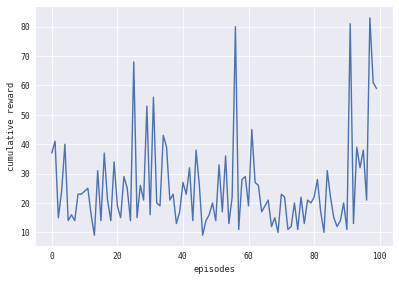

In [5]:
plt.plot(score_list)
plt.xlabel('episodes')
plt.ylabel('cumulative reward')
plt.show()

# Learning - stochastic policy

In [6]:
metric = 0
score_list = []
# --------------- perform online learning ----------------------
while metric<999: # stop learning when metric is larger than 999                              
    observation = env.reset() # reset environment for each new episode
    done = False            
    total_r = 0
    # while episode is not terminate
    while done == False:
        action = agent.pick_action(observation)             # agent pick action
        observation_, reward, done, info = env.step(action) # env return new state and reward
        agent.get_reward(reward, observation_)              # agent receive reward and next obs
        if done:
            do = True
                
        total_r = total_r + reward                          # calculate cumulative reward
        observation = observation_

    if metric<999:
        agent.pg_learn(do)                                      # agent updates its memory 
    
    metric = metric* 0.95+0.05*total_r
    score_list.append(total_r)

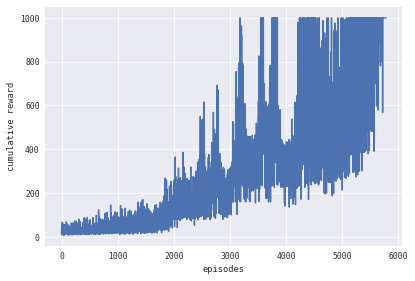

In [7]:
plt.plot(score_list)
plt.xlabel('episodes')
plt.ylabel('cumulative reward')
plt.show()

# Evaluation - deterministic policy

In [8]:
score_list = []
# --------------- perform evaluation ----------------------
for i in range(100):                          
    observation = env.reset() # reset environment for each new episode
    done = False            
    total_r = 0
    # while episode is not terminate
    while done == False:
        action = agent.pick_action_trained(observation)     # agent pick action
        observation_, reward, done, info = env.step(action) # env return new state and reward
                
        total_r = total_r + reward                          # calculate cumulative reward
        observation = observation_

    score_list.append(total_r)

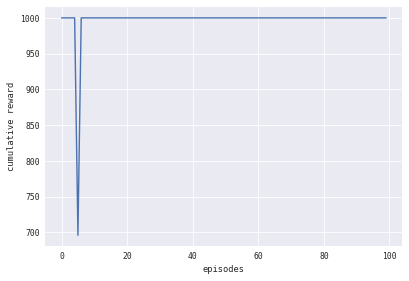

In [9]:
plt.plot(score_list)
plt.xlabel('episodes')
plt.ylabel('cumulative reward')
plt.show()